# Generative Adversarial Networks

Much of this code is modified from: 
https://www.tensorflow.org/tutorials/generative/dcgan

[This version differs from the tensorflow.org method by using backprop through the discriminator network to train the generator.]

GANs are an interesting method whose purpose is to generate data that "looks like" some other dataset.  This is essentially the problem of sampling from an implicit distribution.  If you give me a distribution $p(x)$, I might want to generate samples $\hat{x}$ that have high values of $p(x)$, or even better, generate samples $\hat{x}$ such that they have the same distribution $p(\hat{x}) = p(x)$.  This is harder than it sounds, because while we might be able to estimate the probability that something is a picture of a movie star, it is very hard to generate new pictures that like movie stars.

GANs solve an even harder problem, which is that the distribution $p(x)$ is not given to us, but instead is implicit in a particular set of samples $\{x \}$.  In other words, our goal is:

*Given a set of training samples $x$ drawn from an unknown distribution $p(x)$, construct a network that can generate new samples $\hat{x}$ drawn from this same distribution.*

The way GANs do this is by having two interacting "adversarial" networks.  

1. **generator**: creates fake samples $\hat{x}=g(z)$, where $z$ is random input
2. **discriminator**: determines whether a sample if drawn from the true distribution $x \sim p(x)$ or the generator's distribution $\hat{x} \sim p(\hat{x})$

The two networks learn at the same time, using loss functions that are slightly different:

1. **generator loss function**: fool the discriminator into thinking the sample is real
2. **discriminator loss function**: correctly identify real vs. fake samples

Suppose the discriminator calculates $y=d(x)$ where $y=0$ indicates $x$ is fake, and $y=1$ indicates $x$ is real (the likelihood $p(x)$ is high).  To train the discrininator, we use a combined supervised training set $\{ [realdata, fakedata], [1, 0] \}$.  The cost function will be the cross-entropy between the output $\hat{y}$ and the real class 0 or 1.

Then we fix the weights of the discriminator, and train the generator function $\hat{x} = g(z)$ on random data in order to generate outputs that the discriminator thinks is real.  Thus we create a combined network $\hat{y} = d(\hat{x}) = d(g(z))$ and set the desired target to be $y=1$ for all inputs.  Inputs that already fool the discriminator will have zero error, whereas inputs that do not fool the discriminator will have an error of 1.  


Then the cycle continues, back and forth between the two networks.


In [143]:
#The usual preamble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from keras import layers
import time

import tensorflow as tf
from scipy import signal

#for your homework
np.random.seed(10327798)
tf.random.set_seed(10327798)

In [144]:
BATCH_SIZE = 16

##Generator model
 We are going to build the models using the functional API.  There are separate models for the generator and discriminator, as well as separate loss functions.

In [145]:
def make_generator_model(n_inputs):
    model = tf.keras.Sequential()
    model.add(layers.Dense(40, batch_input_shape=(None,n_inputs), activation='ReLU'))
    model.add(layers.GaussianNoise(0.1))
    model.add(layers.Dense(40, activation='relu'))
    model.add(layers.Dense(40, activation='relu'))
    model.add(layers.Dense(n_inputs))

    return model

In [146]:
#now, make the generator using the function we just created
nInputs = 2
generator = make_generator_model(nInputs)

##  Discriminator model


In [147]:
def make_discriminator_model(n_inputs):
    model = tf.keras.Sequential()
    model.add(layers.Dense(40, batch_input_shape=(None, n_inputs), activation='ReLU'))
    model.add(layers.Dense(40, activation='ReLU'))
    model.add(layers.Dense(1))  #output can be -\infty .. \infty
        #if we wanted the output to be in 0..1 could add a sigmoid nonlinearity

    return model

In [148]:
discriminator = make_discriminator_model(nInputs)

## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [149]:
# This method returns a helper function to compute cross entropy loss
#  It creates a function cross_entropy(y_true, y_predicted)
#  when logits=True is set, y_predicted is in -\infty .. \infty, otherwise in 0..1
#  y_true is always in 0..1
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [150]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  #how often does it correctly identify a real data point
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  #how often does it correctly reject a fake data point
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. The generator wants the discriminator to classify the fake images as real (or 1). So the loss function compares the discriminators decisions on the generated (fake) images to an array of 1s.

In [151]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  #how often does the discriminator think a fake point is true(1)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [152]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Define the training loop


In [153]:
#num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
#seed = tf.random.normal([num_examples_to_generate, nInputs])

Here is the main training loop for one batch of data.  We do this manually not just to show how it can be done, but also to ensure that the gradients are calculated properly.

The "with gradientTape()" statement causes all the trainable variables that change within the with block to be watched every time something changes them.  This allows the gradientTape object to figure out the relationship between the changes in the variables (which in this case are the weights of the network) and the changes in the loss function.  It essentially watches every mathematical operation that actually happens.  This is the magic that makes gradient descent possible in TensorFlow.  Then once all of those calculations are done,  gradientTape.gradient() gives the gradient values for each of the watched variables. 

Notice that this means gradientTape() knows the relationship between the generator_loss() (which depends on the discriminator output) and all the variables within the generator itself.  It thus effectively backpropagates *through* the discriminator.

Finally, the optimizers use those gradient values to figure out how to change the weights.

In [154]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(real_data):
    noise = tf.random.normal([BATCH_SIZE, nInputs])  #random input for this step

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:   #tapes will watch all the trainable variables
      generated_data = generator(noise, training=True)   #this is the generator prediction

      real_output = discriminator(real_data, training=True)   #discriminator outputs on the real data, hopefully mostly 1
      fake_output = discriminator(generated_data, training=True)  #discriminator outputs on the fake data; discriminator wants these to be 0, generator wants these to be 1

      gen_loss = generator_loss(fake_output)  #how different is discriminator(fake_data) from 1's
      disc_loss = discriminator_loss(real_output, fake_output)  #how well does discriminator discriminate

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)  #find the gradients based on the relative changes in the variables
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))  #gradient descent on the weights
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [155]:
#This is the actual training step.  Each epoch generates a series of batches.
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for iData in range(len(dataset)):
      data_batch = dataset[iData:iData+BATCH_SIZE,:]  #batches are overlapping
      train_step(data_batch)   #train one mini-batch

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, it's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).


First step is to generate the "true" dataset.  In this case a half-circle

Text(0.5, 1.0, 'Real Dataset')

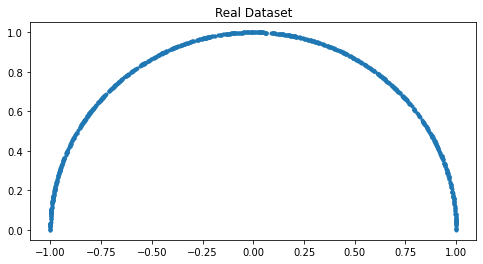

In [156]:
from numpy.random import default_rng
from numpy import linalg as LA

rng = default_rng()
npoints = 1000
theta = np.pi * rng.random(npoints)  #original data are one dimensional
data_x = np.cos(theta).reshape(npoints,1)  #embed them in a two dimensional space along a half-circle
data_y = np.sin(theta).reshape(npoints,1)
halfcircle_data = np.hstack([data_x,data_y])  #x,y coordinates of each point
plt.figure(figsize=(8,4))
plt.plot(data_x,data_y,'.');
plt.title('Real Dataset')

In [157]:
#see how well the generator produced points near the set of training points
def show_result():
  generator_input = rng.random(halfcircle_data.shape)
  fake_data = generator(generator_input)
  fake_data_discrim = discriminator(fake_data)
  plt.figure(figsize=(8,4))
  plt.plot(halfcircle_data[:,0], halfcircle_data[:,1],'r.');
  plt.plot(fake_data[:,0], fake_data[:,1],'b.');
  plt.title('Generator output')
  return fake_data

In [158]:
#see how well the discrimninator performs
def show_test_points(fake_data):
  ntestpoints = 5000
  test_points = np.concatenate((2*rng.random((ntestpoints,1))-1,1.3*rng.random((ntestpoints,1))),axis=1)
  fake_points = fake_data.numpy()
  test_discrim = discriminator(test_points).numpy().reshape(ntestpoints,)
  pos_points = test_points[test_discrim>0,:]
  neg_points = test_points[test_discrim<0,:]
  test_discrim1 = discriminator(fake_points).numpy().reshape(npoints,)
  pos_points1 = fake_points[test_discrim1>0,:]
  neg_points1 = fake_points[test_discrim1<0,:]

  plt.figure(figsize=(8,6))
  plt.plot(halfcircle_data[:,0], halfcircle_data[:,1],'y.');
  plt.plot(fake_data[:,0], fake_data[:,1],'g.');
  plt.plot(neg_points[:,0],neg_points[:,1], 'r.');
  plt.plot(pos_points[:,0],pos_points[:,1], 'b.');
  plt.title('Discriminator pos/neg regions')

  plt.figure(figsize=(8,6))
  plt.plot(halfcircle_data[:,0], halfcircle_data[:,1],'y.');
  plt.plot(pos_points1[:,0],pos_points1[:,1], 'bo');
  plt.plot(neg_points1[:,0],neg_points1[:,1], 'ro');
  plt.title('Discriminator performance on fake data')



In [159]:
### Here is where the training actually happens

Time for epoch 1 is 8.582086086273193 sec
Time for epoch 2 is 1.825021743774414 sec
Time for epoch 1 is 1.8034961223602295 sec
Time for epoch 2 is 1.776820182800293 sec
Time for epoch 1 is 1.8077759742736816 sec
Time for epoch 2 is 1.8058154582977295 sec
Time for epoch 1 is 1.8148832321166992 sec
Time for epoch 2 is 1.83186936378479 sec
Time for epoch 1 is 1.8158206939697266 sec
Time for epoch 2 is 1.7939982414245605 sec


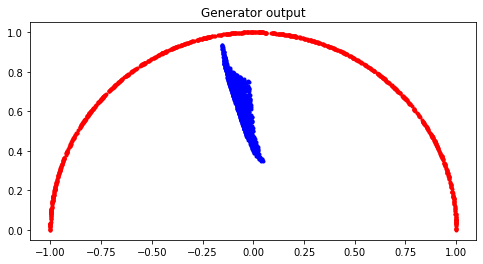

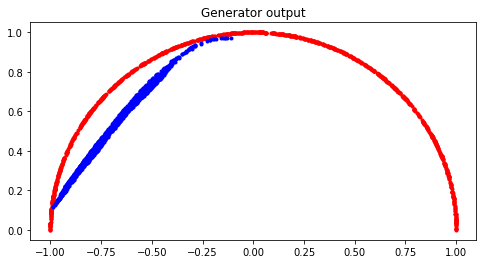

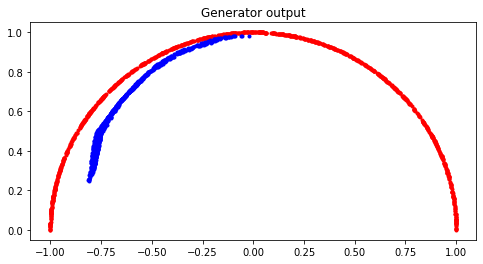

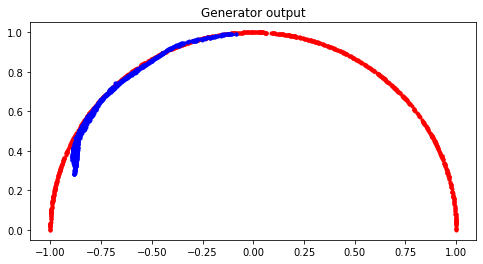

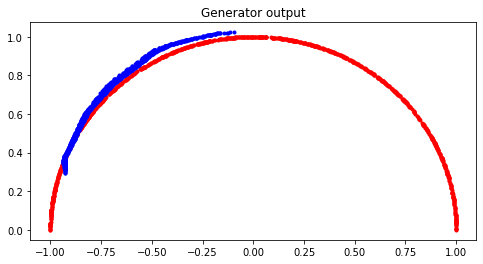

In [160]:
#The Training!
EPOCHS = 2
repeat = 5
for n in range(repeat):
  train(halfcircle_data, EPOCHS)
  show_result()
  

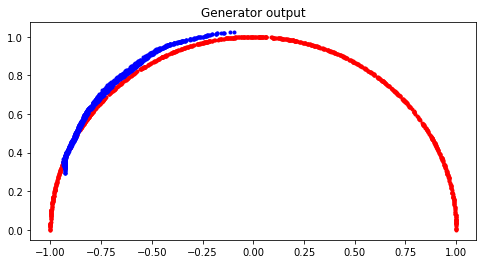

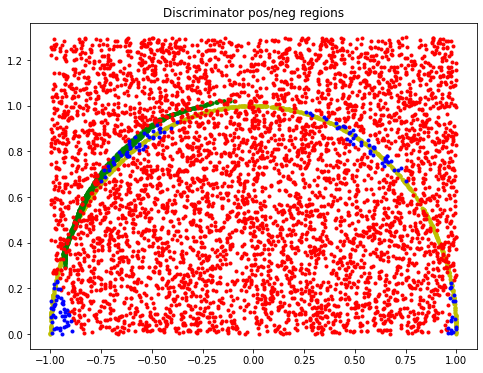

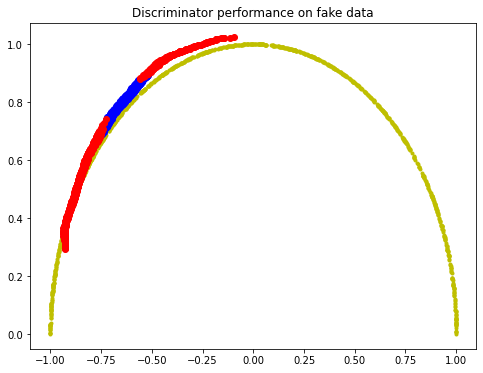

In [161]:
  #now show the results for the generator and discriminator performance
  fake_data = show_result();
  show_test_points(fake_data);